# Сверточные нейронные сети - CNN

## на примере датасета MNIST

### Загрузка стандартных библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()
%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 10.0

### Библиотеки машинного обучения: Keras и Scikit-Learn

In [2]:
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report, confusion_matrix

from keras.datasets import mnist

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Flatten

from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras import backend as K

random_state = 42

batch_size = 128
num_classes = 10
epochs = 10

N, M = 28, 28

Using TensorFlow backend.


### Описание датасета

In [3]:
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

### Загрузка датасета

Два способа:
- с помощью sklearn
- с помощью keras (данные уже разбиты на тренировочный и тестовый наборы)

In [4]:
# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, N, M)
    x_test = x_test.reshape(x_test.shape[0], 1, N, M)
    input_shape = (1, N, M)
else:
    x_train = x_train.reshape(x_train.shape[0], N, M, 1)
    x_test = x_test.reshape(x_test.shape[0], N, M, 1)
    input_shape = (N, M, 1)

# Sklearn realization
# digits = fetch_openml('mnist_784', version=1, cache=True)
# X, y = digits.data, digits.target
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state)

y_classes = y_test.copy()

In [5]:
# Shapes for train and test
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### Изображение - карта признаков

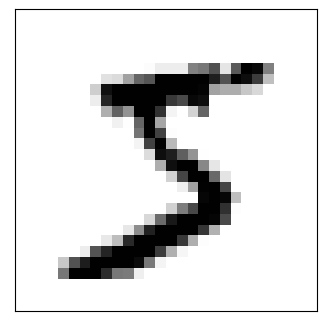

In [6]:
# Plot single digit
plt.figure('Some digit', figsize=(4, 4), dpi=100)
plt.imshow(x_train[0].reshape(28, 28), cmap='binary')
plt.xticks([], [])
plt.yticks([], [])
plt.grid(False)

### Набор рукописных цифр

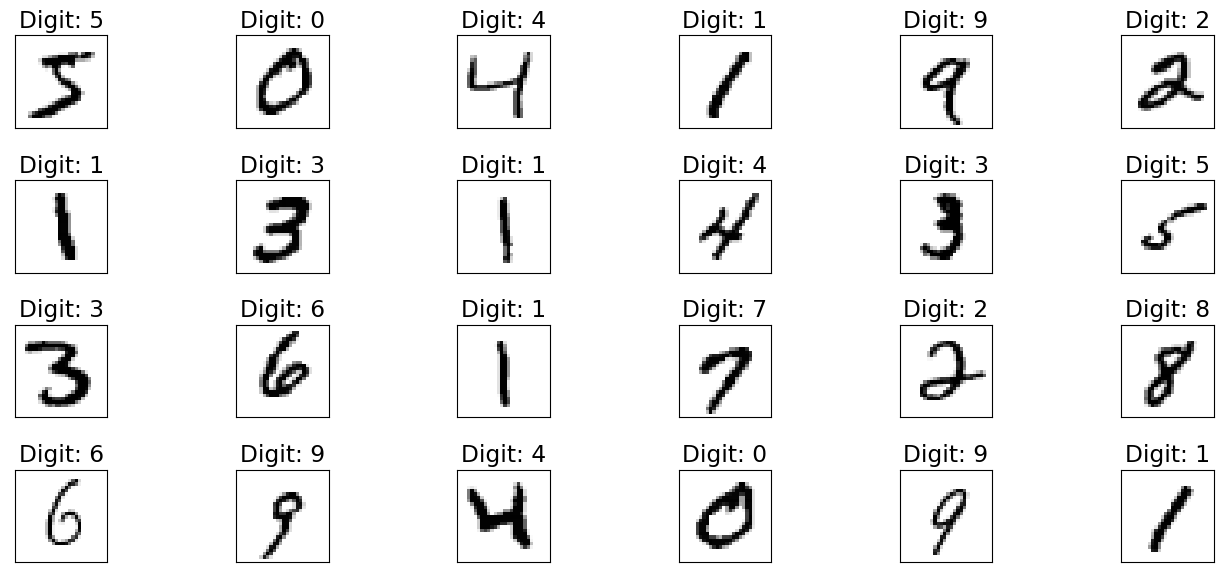

In [7]:
# Plot some digits
plt.figure('MNIST Dataset', figsize=(14, 6), dpi=100)
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='binary')
    plt.title('Digit: {}'.format(y_train[i]))
    plt.grid(False)
    plt.xticks([], [])
    plt.yticks([], [])
plt.tight_layout()

### Подготовка данных

- Преобразование размерностей,
- Масштабирование признаков (нормализация в диапазон [0, 1]),
- Преборазование категориальных меток.

In [8]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test  samples')

# One-hot label encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

60000 train samples
10000 test  samples


### CNN

- Свертка с ядром 3х3, 32 канала
- Функция активации ReLU
- Свертка с ядром 3х3, 64 канала
- Функция активации ReLU
- Децимация размерности MaxPooling 2x2
- Регуляризация, rate = 0.25
- Слой "спрямления"
- Полносвязный слой, 128 нейронов
- Функция активации ReLU
- Регуляризация, rate = 0.5
- Нормализация мини-батчей
- Полносвязный слой (число нейронов = число классов)
- Фунция активации Softmax

In [9]:
# Create CNN in two steps
input_shape = (N, M, 1)
np.random.seed(random_state)

model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer='he_normal', input_shape=input_shape))
model_cnn.add(Activation('relu'))
model_cnn.add(Conv2D(32, (3, 3), kernel_initializer='he_normal'))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25, seed=random_state))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.5, seed=random_state))
model_cnn.add(Dense(num_classes, activation='softmax'))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

### Начальная инициализация нейронов

In [10]:
init_weights = model_cnn.get_weights()

weights_l1 = init_weights[0]
weights_l2 = init_weights[2]

weights_l1.shape, weights_l2.shape

((3, 3, 1, 32), (3, 3, 32, 32))

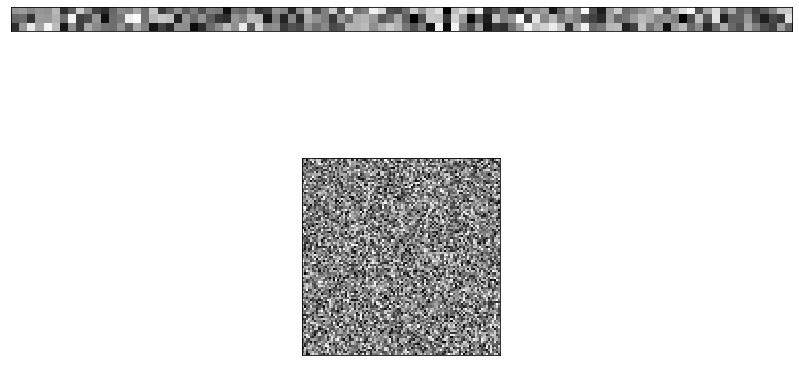

In [11]:
# Plot single digit
plt.figure('Some digit', figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.imshow(
    weights_l1.reshape(
        weights_l1.shape[0] * weights_l1.shape[2], 
        weights_l1.shape[1] * weights_l1.shape[3]
    ), 
    cmap='binary'
)

plt.xticks([], []); plt.yticks([], [])
plt.grid(False)
plt.subplot(2, 1, 2)
plt.imshow(
    weights_l2.reshape(
        weights_l2.shape[0] * weights_l2.shape[2], 
        weights_l2.shape[1] * weights_l2.shape[3]
    ), 
    cmap='binary'
)
plt.xticks([], []); plt.yticks([], [])
plt.grid(False)

### Функция потерь и метрики

- Функция потерь: категориальная кросс-энтропия,
- Метрика: точность (аккуратность),
- Алгоритм - RMS Propagation.


In [12]:
model_cnn.compile(
    optimizer=RMSprop(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Обучение модели

In [13]:
clf_cnn = model_cnn.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        workers=4,
                        validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 37s 610us/step - loss: 0.1697 - accuracy: 0.9490 - val_loss: 0.0531 - val_accuracy: 0.9818
Epoch 2/10
60000/60000 [==============================] - 45s 746us/step - loss: 0.0685 - accuracy: 0.9794 - val_loss: 0.0419 - val_accuracy: 0.9868
Epoch 3/10
60000/60000 [==============================] - 39s 657us/step - loss: 0.0547 - accuracy: 0.9835 - val_loss: 0.0381 - val_accuracy: 0.9882
Epoch 4/10
60000/60000 [==============================] - 41s 685us/step - loss: 0.0459 - accuracy: 0.9859 - val_loss: 0.0305 - val_accuracy: 0.9902
Epoch 5/10
60000/60000 [==============================] - 38s 639us/step - loss: 0.0402 - accuracy: 0.9877 - val_loss: 0.0400 - val_accuracy: 0.9883
Epoch 6/10
60000/60000 [==============================] - 38s 627us/step - loss: 0.0358 - accuracy: 0.9889 - val_loss: 0.0381 - val_accuracy: 0.9883
Epoch 7/10
60000/60000 [==============================] 

### Сохранение результатов модели

In [14]:
# model_cnn.save_weights('model_cnn.h5')

### Точность и потери

In [15]:
score = model_cnn.evaluate(x_test, y_test)

print(f'Test loss     : {score[0]:0.6f}\nTest accuracy : {score[1]:0.6f}')

10000/10000 [==============================] - 2s 174us/step
Test loss     : 0.032438
Test accuracy : 0.990800


### График функции потерь и точности на каждой эпохе

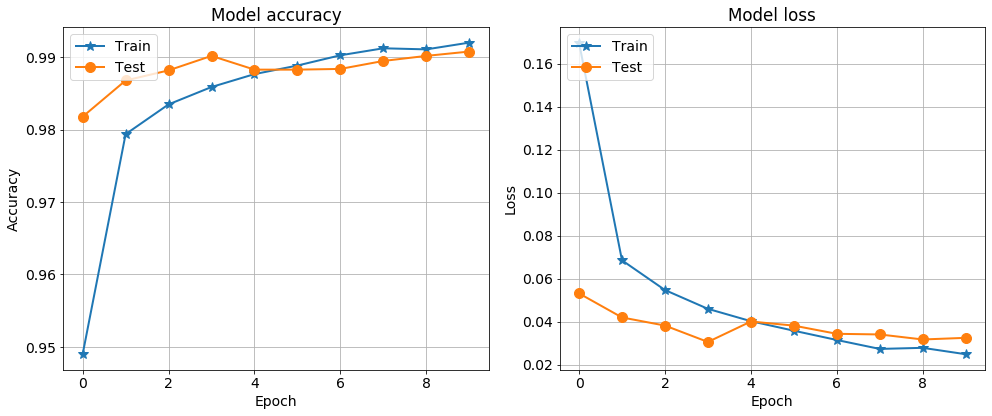

In [16]:
# Plot training & validation loss / accuracy values
plt.figure('Loss & Accuracy', figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(clf_cnn.history['accuracy'], '*-')
plt.plot(clf_cnn.history['val_accuracy'], 'o-')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(clf_cnn.history['loss'], '*-')
plt.plot(clf_cnn.history['val_loss'], 'o-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.tight_layout()

### Матрица ошибок

In [17]:
y_predict = model_cnn.predict_classes(x_test)

# Confusion matrix
conf_digits = confusion_matrix(y_classes, y_predict)
print(conf_digits)

[[ 979    0    0    1    0    0    0    0    0    0]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   1    0 1025    0    1    0    0    5    0    0]
 [   0    0    3 1005    0    1    0    0    1    0]
 [   0    0    1    0  975    0    0    0    0    6]
 [   2    1    0    7    0  881    1    0    0    0]
 [   5    4    0    1    1    3  944    0    0    0]
 [   0    2    6    2    0    0    0 1018    0    0]
 [   5    1    4    0    1    0    2    2  955    4]
 [   0    1    0    2    4    5    0    4    1  992]]


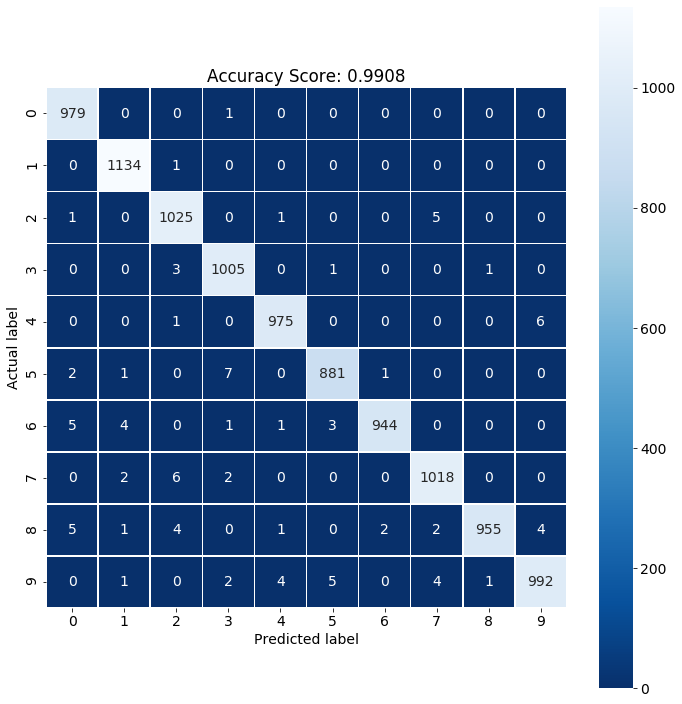

In [18]:
plt.figure('Confusion matrix', figsize=(10, 10))
sns.heatmap(conf_digits, annot=True, linewidths=.75, fmt=".0f", square=True, cmap='Blues_r');
plt.xlabel('Predicted label');
plt.ylabel('Actual label');
plt.title('Accuracy Score: {:.6}'.format(score[1]));
plt.tight_layout()

### Результат

In [19]:
print(classification_report(y_classes, y_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### Прохождение экземпляров через нейронную сеть

Посмотрим, как меняются состояния внутренних слоев при прохождении единичных объектов через сеть.

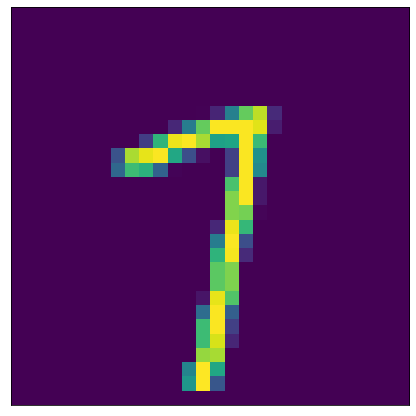

In [20]:
test_image = x_train[42]

plt.figure('Test image', figsize=(6, 6))
plt.imshow(test_image.reshape(28, 28), 
           cmap='viridis', 
           interpolation='none')
plt.grid(False)
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()

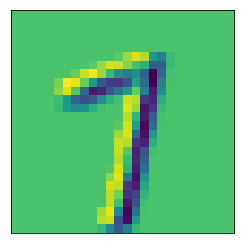

In [21]:
layer_outs = [layer.output for layer in model_cnn.layers[:8]]

activation_model = Model(
    input=model_cnn.input, 
    output=layer_outs
)

activations = activation_model.predict(test_image.reshape(1, 28, 28,1))

first_layer_activation = activations[0]

#plt.figure('Test image', figsize=(6, 6))
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.grid(False)
plt.xticks([], [])
plt.yticks([], [])
plt.tight_layout()

In [22]:
model_cnn.layers[:]

### Прохождение данных через сверточные слои

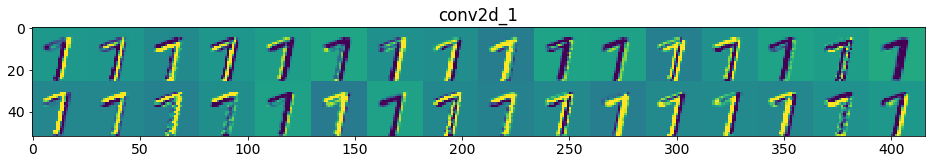

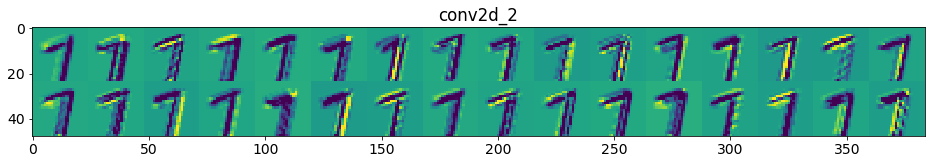

In [23]:
layer_names = []

for layer in model_cnn.layers[:-1]:
    layer_names.append(layer.name)
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')